## Load package

In [1]:
from logging import exception
import os
from platform import architecture
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
import torch_geometric.nn as geom_nn
from torch_geometric.nn import GCNConv
import networkx as nx
# import feature_embedding
# import PDB2Graph
import GNN_core
import argparse
import random
from os.path import exists
from multiprocessing import Pool
import multiprocessing
import torch.optim as optim
import copy
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import os
import glob

## Set training parameters and load graph

In [2]:
# set parameters
lr = 0.01
n_epochs = 100 
patience = n_epochs
ratio = [0.6, 0.2, 0.2]
batch_size = 40
hidden_channels = 12

# load graph
all_graph_path = './new_data_base/all_graph_PDB_MinMax/'
nx_files = glob.glob(os.path.join(all_graph_path, '*.nx'))
print('Total graph:',len(nx_files))

graph_dataset = [];
for i, tmp_path in enumerate(nx_files):
    loaded_data = torch.load(tmp_path)
    graph_dataset.append(loaded_data)

# print out one graph info for checking
idx_eg = 3
data = graph_dataset[idx_eg]
# print(graph_dataset[1].edge_attr)
print()
print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print('Current nx path:{}'.format(nx_files[idx_eg]))

Total graph: 314

Data(x=[377, 8], edge_index=[2, 1037], y=1)
Number of nodes: 377
Number of edges: 1037
Average node degree: 2.75
Current nx path:./new_data_base/all_graph_PDB_MinMax/5GU6.nx


## Balance the data and set train/val/test set

In [3]:
# balance the data
random.seed(666)

print('____')
print('Before balance')
print('length graph_dataset',len(graph_dataset))
sum_i = 0
for i in graph_dataset:
    sum_i = sum_i + i.y

print('#Label1 and ration:',sum_i,sum_i/len(graph_dataset))
print('____')

### train test partition
graph_dataset=GNN_core.balance_dataset(graph_dataset)
print('____')
print('After balance')
print('length graph_dataset',len(graph_dataset))
sum_i = 0
for i in graph_dataset:
    sum_i = sum_i + i.y

print('#Label1 and ration:',sum_i,sum_i/len(graph_dataset))
GNN_core.get_info_dataset(graph_dataset,verbose=True)
print('____')

#train_test_partition=int(partition_ratio*len(graph_dataset))
assert(ratio[0]+ratio[1]+ratio[2]==1)
part1 = int(len(graph_dataset)*ratio[0])
part2 = part1 + int(len(graph_dataset)*ratio[1])
part3 = part2 + int(len(graph_dataset)*ratio[2])

train_dataset = graph_dataset[:part1]
test_dataset = graph_dataset[part1:part2]
val_dataset = graph_dataset[part2:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

print('____')
print('Length test_dataset',len(test_dataset))
sum_i = 0
for i in test_dataset:
    sum_i = sum_i + i.y

print('#Label1 and ration:',sum_i,sum_i/len(test_dataset))
GNN_core.get_info_dataset(test_dataset,verbose=True)
print('____')
print('Data info for checking randomness:')
for i, data in enumerate(val_dataset):
    print(data)
    if i == 10:
        break

____
Before balance
length graph_dataset 314
#Label1 and ration: tensor(121) tensor(0.3854)
____
____
After balance
length graph_dataset 251
#Label1 and ration: tensor(121) tensor(0.4821)
In this dataset, there are 130 inputs labeled "0" and 121 inputs labeled "1".
____
Number of training graphs: 150
Number of test graphs: 50
Number of val graphs: 51
____
Length test_dataset 50
#Label1 and ration: tensor(22) tensor(0.4400)
In this dataset, there are 28 inputs labeled "0" and 22 inputs labeled "1".
____
Data info for checking randomness:
Data(x=[712, 8], edge_index=[2, 1754], y=1)
Data(x=[1092, 8], edge_index=[2, 3000], y=1)
Data(x=[5045, 8], edge_index=[2, 12994], y=1)
Data(x=[207, 8], edge_index=[2, 526], y=1)
Data(x=[206, 8], edge_index=[2, 1710], y=0)
Data(x=[711, 8], edge_index=[2, 2971], y=1)
Data(x=[307, 8], edge_index=[2, 835], y=1)
Data(x=[799, 8], edge_index=[2, 2315], y=0)
Data(x=[5205, 8], edge_index=[2, 14460], y=1)
Data(x=[1833, 8], edge_index=[2, 4979], y=1)
Data(x=[2727,

## Define the model

In [4]:
import GNN_core

from importlib import reload
reload(GNN_core)

from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
### core GNN 
num_node_features=len(graph_dataset[0].x[0])
num_classes=2

# arch = 'GCN'
arch = 'GAT_jz'
num_layers = 0
print(arch)
if arch == 'GCN':
    model = GNN_core.GCN(hidden_channels,num_node_features=num_node_features,num_classes=num_classes,num_layers=num_layers)
if arch == 'GNN':
    model = GNN_core.GNN(hidden_channels,num_node_features=num_node_features,num_classes=num_classes,num_layers=num_layers)
if arch == 'GTN':
    heads = 1
    model = GNN_core.GTN(hidden_channels,num_node_features=num_node_features,
                         num_classes=num_classes,num_layers=num_layers,heads=heads)
if arch == 'GAT_jz':
    heads = 1
    model = GNN_core.GAT_jz(hidden_channels,num_node_features=num_node_features,
                            num_classes=num_classes,num_layers=num_layers,heads=heads)
    
print(type(model))  

### randomly initialize model parameters
for layer in model.children():
    if isinstance(layer, GCNConv):
        dic = layer.state_dict()
        for k in dic:
            dic[k] = torch.randn(dic[k].size())
        layer.load_state_dict(dic)
        del(dic)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.0001)
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

best_val_acc = 0
best_val_epoch = 0
best_model=None

model

GAT_jz
<class 'GNN_core.GAT_jz'>


GAT_jz(
  (linear): Linear(in_features=8, out_features=8, bias=True)
  (bn0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GATConv(8, 12, heads=1)
  (bn1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(12, 12, heads=1)
  (bn2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(12, 12, heads=1)
  (bn3): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): ModuleList()
  (bn): ModuleList()
  (lin): Linear(in_features=12, out_features=2, bias=True)
)

## Train and save the model - if model exists, do not run these two cells

new best validation score 0.49019607843137253
new best validation score 0.5098039215686274
new best validation score 0.6470588235294118
Epoch: 020, Train Acc: 0.6267, Test Acc: 0.4600,Train loss: 0.0214, Test loss: 0.0907
Epoch: 040, Train Acc: 0.7667, Test Acc: 0.5200,Train loss: 0.0122, Test loss: 0.0583
new best validation score 0.7058823529411765
Epoch: 060, Train Acc: 0.8333, Test Acc: 0.5600,Train loss: 0.0072, Test loss: 0.1116
new best validation score 0.7450980392156863
Epoch: 080, Train Acc: 0.8800, Test Acc: 0.5200,Train loss: 0.0068, Test loss: 0.1106
score on train set: 0.9866666666666667
score on val set: 0.7450980392156863
score on test set: 0.64

Performace on val set

  AUC: 0.7430769230769231
  confusion matrix: [tn 22, fp 4, fn 9, tp 16]
  precision = 0.8
  recall = 0.64
0.743 0.987 0.64 0.8 0.64 22 4 9 16



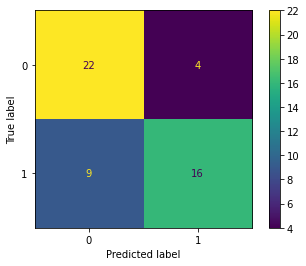


Performace on test set

  AUC: 0.6444805194805194
  confusion matrix: [tn 17, fp 11, fn 7, tp 15]
  precision = 0.5769230769230769
  recall = 0.6818181818181818
0.644 0.987 0.64 0.577 0.682 17 11 7 15

./new_data_base/all_graph_PDB_MinMax/


In [5]:
### training
for epoch in range(1, int(n_epochs)):

    GNN_core.train(model=model,train_loader=train_loader,optimizer=optimizer,criterion=criterion)
    
#     print(epoch)
#     break
    
    train_acc = GNN_core.test(model=model,loader=train_loader)
    test_acc = GNN_core.test(model=model,loader=test_loader)

    test_loss=GNN_core.loss(model=model,loader=test_loader,criterion=criterion).item()
    train_loss=GNN_core.loss(model=model,loader=train_loader,criterion=criterion).item()

    this_val_acc = GNN_core.test(model=model,loader=val_loader)
    if epoch %20==0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f},Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')

    if this_val_acc > best_val_acc: #validation wrapper
        best_val_epoch = epoch
        best_val_acc=this_val_acc
        best_model= copy.deepcopy(model)
        patience_counter = 0
        print(f"new best validation score {best_val_acc}")
    else:
        patience_counter+=1
    if patience_counter == patience:
        print("ran out of patience")
        print('Current epoch:',epoch)
        break

trainscore = GNN_core.test(model=best_model,loader=train_loader)
testscore = GNN_core.test(model=best_model,loader=test_loader)
valscore = GNN_core.test(model=best_model,loader=val_loader)
print(f'score on train set: {trainscore}')
print(f'score on val set: {valscore}')
print(f'score on test set: {testscore}')


### testing on val set
print('\nPerformace on val set')
predict_test = GNN_core.predict(model=best_model,loader=val_loader)
label_test=[]
for data in val_loader:
    label_test.append(data.y.tolist())

label_test=[item for sublist in label_test for item in sublist]
predict_test=[item for sublist in predict_test for item in sublist]
#predict_test=np.array(predict_test).ravel()

fpr1, tpr1, thresholds = roc_curve(label_test, predict_test)
tn, fp, fn, tp = confusion_matrix(label_test, predict_test).ravel()
AUROC = auc(fpr1, tpr1)
print()
print(f'  AUC: {AUROC}')
print(f"  confusion matrix: [tn {tn}, fp {fp}, fn {fn}, tp {tp}]")
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(f'  precision = {precision}')
print(f'  recall = {recall}')
# print(args)
print(round(AUROC,3),round(trainscore,3),round(testscore,3),round(precision,3),round(recall,3),tn, fp, fn, tp)
print()

cm = confusion_matrix(label_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                           display_labels=[0,1])
disp.plot()
plt.show()

### testing on testing set
print('\nPerformace on test set')
predict_test = GNN_core.predict(model=best_model,loader=test_loader)
label_test=[]
for data in test_loader:
    label_test.append(data.y.tolist())

label_test=[item for sublist in label_test for item in sublist]
predict_test=[item for sublist in predict_test for item in sublist]
#predict_test=np.array(predict_test).ravel()

fpr1, tpr1, thresholds = roc_curve(label_test, predict_test)
tn, fp, fn, tp = confusion_matrix(label_test, predict_test).ravel()
AUROC = auc(fpr1, tpr1)
print()
print(f'  AUC: {AUROC}')
print(f"  confusion matrix: [tn {tn}, fp {fp}, fn {fn}, tp {tp}]")
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(f'  precision = {precision}')
print(f'  recall = {recall}')
# print(args)
print(round(AUROC,3),round(trainscore,3),round(testscore,3),round(precision,3),round(recall,3),tn, fp, fn, tp)
print()
print(all_graph_path)

In [ ]:
# save model
# best_model_wts = copy.deepcopy(best_model.state_dict())
# save_path = os.path.join('.','model','{}_best_model.pth'.format(arch))
# print(save_path)
# torch.save(best_model_wts, save_path)

## Load best model

In [6]:
import GNN_core

from importlib import reload
reload(GNN_core)
# load model
# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if arch == 'GCN':
    best_model = GNN_core.GCN(hidden_channels,num_node_features=num_node_features,num_classes=num_classes,num_layers=num_layers)
if arch == 'GNN':
    best_model = GNN_core.GNN(hidden_channels,num_node_features=num_node_features,num_classes=num_classes,num_layers=num_layers)
if arch == 'GTN':
    best_model = GNN_core.GTN(hidden_channels,num_node_features=num_node_features,num_classes=num_classes,num_layers=num_layers)
if arch == 'GAT_jz':
    heads = 1
    best_model = GNN_core.GAT_jz(hidden_channels,num_node_features=num_node_features,
                            num_classes=num_classes,num_layers=num_layers,heads=heads)
    

save_path = os.path.join('.','model','{}_best_model.pth'.format(arch))
best_model.load_state_dict(torch.load(save_path))
model.to(device)
model.eval()

cuda


GAT_jz(
  (linear): Linear(in_features=8, out_features=8, bias=True)
  (bn0): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GATConv(8, 12, heads=1)
  (bn1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(12, 12, heads=1)
  (bn2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(12, 12, heads=1)
  (bn3): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): ModuleList()
  (bn): ModuleList()
  (lin): Linear(in_features=12, out_features=2, bias=True)
)

## Import package and inference dataloader

In [7]:
from torch_geometric.data import Data
from torch_geometric.explain import \
    Explainer, Explanation, GNNExplainer, CaptumExplainer, PGExplainer

# data = Data(...)  # A homogeneous graph data object.
coeffs = {
        'edge_size': 0.005,
        'edge_reduction': 'sum',
        'node_feat_size': 1.0,
        'node_feat_reduction': 'mean',
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
        'EPS': 1e-15,
    }

# data=graph_dataset[1]
ex_loader = DataLoader(val_dataset[:], batch_size=1, shuffle=False)
for i, data in enumerate(ex_loader):
    print(i,data)
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    if i==2:
        break

0 DataBatch(x=[712, 8], edge_index=[2, 1754], y=[1], batch=[712], ptr=[2])
Number of nodes: 712
Number of edges: 1754
Average node degree: 2.46
1 DataBatch(x=[1092, 8], edge_index=[2, 3000], y=[1], batch=[1092], ptr=[2])
Number of nodes: 1092
Number of edges: 3000
Average node degree: 2.75
2 DataBatch(x=[5045, 8], edge_index=[2, 12994], y=[1], batch=[5045], ptr=[2])
Number of nodes: 5045
Number of edges: 12994
Average node degree: 2.58


## Apply explainer on each graph


Current ID: 0
DataBatch(x=[712, 8], edge_index=[2, 1754], y=[1], batch=[712], ptr=[2])
Number of nodes: 712
Number of edges: 1754
Average node degree: 2.46
Labels: tensor([1])
Batch: torch.Size([712])

Explanation:
Explanation(node_mask=[712, 8], edge_mask=[1754], prediction=[1, 2], target=[1], x=[712, 8], edge_index=[2, 1754], batch=[712])
explanation target: tensor([1])
tensor([[-0.4153,  0.1984]]) tensor([1])
tensor([[ 4.7357, -4.6261]]) tensor([0])


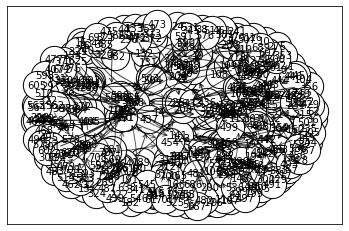

Sum of node_mask: tensor(229.9076) tensor(350)
Sum of edge_mask: tensor(175.6708) tensor(350)
Explanation(node_mask=[712, 8], edge_mask=[1754], prediction=[1, 2], target=[1], x=[712, 8], edge_index=[2, 1754], batch=[712])
Validate: True

Subgraph:
Explanation(node_mask=[281, 8], edge_mask=[61], prediction=[1, 2], target=[1], x=[281, 8], edge_index=[2, 61], batch=[281])
Sum of node_mask: tensor(229.9076)
Sum of edge_mask: tensor(31.5097)

visualize_feature_importance:


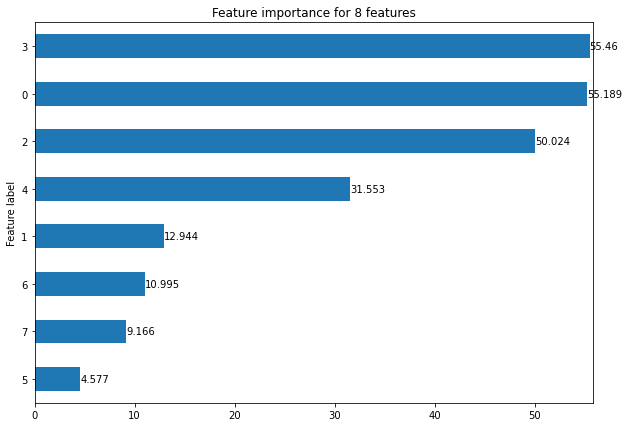


Current ID: 1
DataBatch(x=[1092, 8], edge_index=[2, 3000], y=[1], batch=[1092], ptr=[2])
Number of nodes: 1092
Number of edges: 3000
Average node degree: 2.75
Labels: tensor([1])
Batch: torch.Size([1092])

Explanation:
Explanation(node_mask=[1092, 8], edge_mask=[3000], prediction=[1, 2], target=[1], x=[1092, 8], edge_index=[2, 3000], batch=[1092])
explanation target: tensor([1])
tensor([[-1.5850,  1.3585]]) tensor([1])
tensor([[ 3.7348, -3.6525]]) tensor([0])


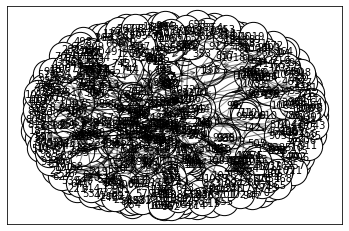

Sum of node_mask: tensor(399.0798) tensor(600)
Sum of edge_mask: tensor(274.8344) tensor(600)
Explanation(node_mask=[1092, 8], edge_mask=[3000], prediction=[1, 2], target=[1], x=[1092, 8], edge_index=[2, 3000], batch=[1092])
Validate: True

Subgraph:
Explanation(node_mask=[436, 8], edge_mask=[171], prediction=[1, 2], target=[1], x=[436, 8], edge_index=[2, 171], batch=[436])
Sum of node_mask: tensor(399.0797)
Sum of edge_mask: tensor(81.2306)

visualize_feature_importance:


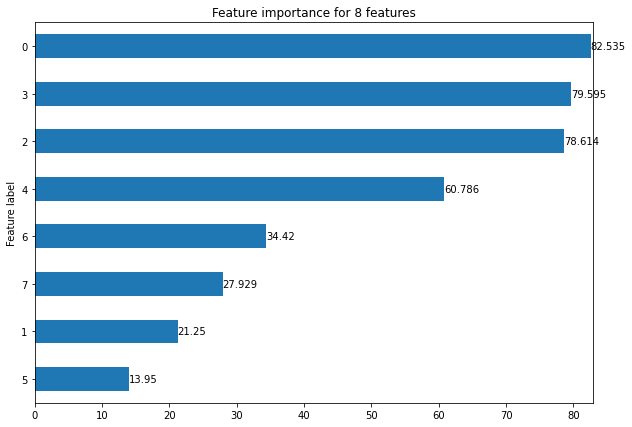


Current ID: 2
DataBatch(x=[5045, 8], edge_index=[2, 12994], y=[1], batch=[5045], ptr=[2])
Number of nodes: 5045
Number of edges: 12994
Average node degree: 2.58
Labels: tensor([1])
Batch: torch.Size([5045])

Explanation:
Explanation(node_mask=[5045, 8], edge_mask=[12994], prediction=[1, 2], target=[1], x=[5045, 8], edge_index=[2, 12994], batch=[5045])
explanation target: tensor([0])
tensor([[ 0.7821, -0.9038]]) tensor([0])
tensor([[ 4.3458, -4.3414]]) tensor([0])


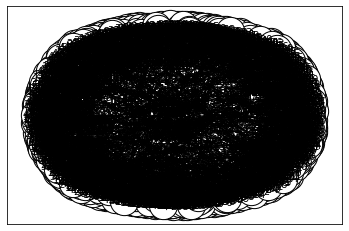

Sum of node_mask: tensor(238.2306) tensor(2598)
Sum of edge_mask: tensor(233.0253) tensor(2598)
Explanation(node_mask=[5045, 8], edge_mask=[12994], prediction=[1, 2], target=[1], x=[5045, 8], edge_index=[2, 12994], batch=[5045])
Validate: True

Subgraph:
Explanation(node_mask=[2046, 8], edge_mask=[446], prediction=[1, 2], target=[1], x=[2046, 8], edge_index=[2, 446], batch=[2046])
Sum of node_mask: tensor(238.2306)
Sum of edge_mask: tensor(40.0141)

visualize_feature_importance:


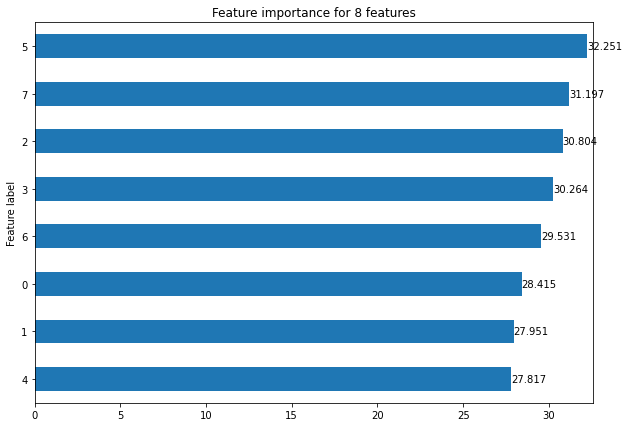

In [31]:
# Generate explanation for the node at index `0`:
for i, data in enumerate(ex_loader):
#     if data.x.shape[0] > 500:
#         continue
        
    print('\nCurrent ID:',i)
    print(data)
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print('Labels:',data.y)
    print('Batch:',data.batch.shape)
    print()
    
    # GNNExplainer
    explainer = Explainer(
        model=best_model,
        algorithm=GNNExplainer(epochs=300, lr=0.01,
                              coeffs=coeffs), ### Please fine tune ###
        explanation_type='model',
        node_mask_type='attributes', # attributes
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='graph',
            return_type='raw',  # Model returns log probabilities.
        ),
        threshold_config=dict(
            threshold_type='topk', #topk_hard
            value=int(data.num_edges*0.2)
        ) ### Please fine tune ###
    )

    explanation = explainer(x=data.x, 
                            edge_index=data.edge_index, 
                            batch = data.batch
                           )
    print('Explanation:')
    print(explanation)
    print('explanation target:',explanation.target)
    
    # get_prediction()
    get_pre = explainer.get_prediction(x=data.x, edge_index=data.edge_index, batch=data.batch)
    get_pre_tar = explainer.get_target(get_pre)
    print(get_pre, get_pre_tar)
    # get_masked_prediction()
    get_mask_pre = explainer.get_masked_prediction(x=data.x, 
                                                   edge_index=data.edge_index, 
                                                   node_mask=explanation.node_mask,
                                                   edge_mask=explanation.edge_mask,
                                                   batch=data.batch)
    get_mask_pre_tar = explainer.get_target(get_mask_pre)
    print(get_mask_pre,get_mask_pre_tar)
    
    ###
    # visualize graph
    explanation.visualize_graph()

    # print(explanation.node_mask[:50])
    print('Sum of node_mask:', torch.sum(explanation.node_mask), torch.sum(explanation.node_mask>0))
    # print(explanation.edge_mask[:50])
    print('Sum of edge_mask:', torch.sum(explanation.edge_mask), torch.sum(explanation.edge_mask>0))
    print(explanation)
    print('Validate:', explanation.validate())

    print('\nSubgraph:')
    subgraph = explanation.get_explanation_subgraph()
    print(subgraph)
    # print(subgraph.edge_mask)
    print('Sum of node_mask:', torch.sum(subgraph.node_mask))
    print('Sum of edge_mask:', torch.sum(subgraph.edge_mask))

#     print('\nComplement_subgraph:')
#     comple_subgraph = explanation.get_complement_subgraph()
#     print(comple_subgraph)

    # visualize feature - importance
    print('\nvisualize_feature_importance:')
    explanation.visualize_feature_importance()

    # below plot only works when threshold_config is not hard
    # visualize sub-graph
#     print('\nvisualize_subgraph:')
#     subgraph.visualize_graph()
    
    ###
    if i == 2:
        break

## Visualize last explanation in above cell

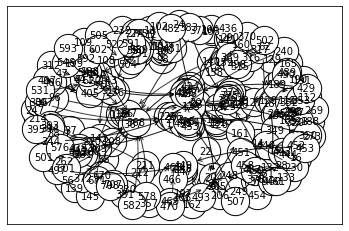

Sum of node_mask: tensor(117.7214) tensor(175)
Sum of edge_mask: tensor(99.2151) tensor(175)
Explanation(node_mask=[712, 8], edge_mask=[1754], prediction=[1, 2], target=[1], x=[712, 8], edge_index=[2, 1754], batch=[712])
Validate: True

Subgraph:
Explanation(node_mask=[146, 8], edge_mask=[14], prediction=[1, 2], target=[1], x=[146, 8], edge_index=[2, 14], batch=[146])
Sum of node_mask: tensor(117.7214)
Sum of edge_mask: tensor(8.1777)

Complement_subgraph:
Explanation(node_mask=[566, 8], edge_mask=[1087], prediction=[1, 2], target=[1], x=[566, 8], edge_index=[2, 1087], batch=[566])

visualize_feature_importance:


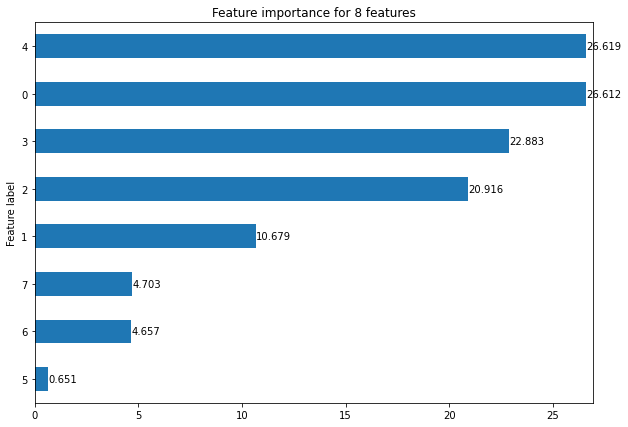


visualize_subgraph:


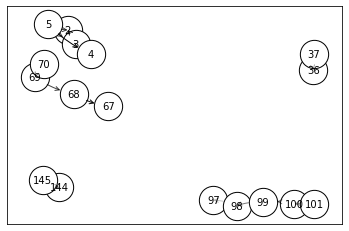

In [22]:
# visualize graph
explanation.visualize_graph()

# print(explanation.node_mask[:50])
print('Sum of node_mask:', torch.sum(explanation.node_mask), torch.sum(explanation.node_mask>0))
# print(explanation.edge_mask[:50])
print('Sum of edge_mask:', torch.sum(explanation.edge_mask), torch.sum(explanation.edge_mask>0))
print(explanation)
print('Validate:', explanation.validate())

print('\nSubgraph:')
subgraph = explanation.get_explanation_subgraph()
print(subgraph)
# print(subgraph.edge_mask)
print('Sum of node_mask:', torch.sum(subgraph.node_mask))
print('Sum of edge_mask:', torch.sum(subgraph.edge_mask))

print('\nComplement_subgraph:')
comple_subgraph = explanation.get_complement_subgraph()
print(comple_subgraph)

# visualize feature - importance
print('\nvisualize_feature_importance:')
explanation.visualize_feature_importance()

# below plot only works when threshold_config is not hard
# visualize sub-graph
print('\nvisualize_subgraph:')
subgraph.visualize_graph()

# print('\nvisualize_complement_subgraph:')
# comple_subgraph.visualize_graph()

## Data to plot
### 1. Adjacency matrix

torch.Size([2, 12994])
torch.Size([1, 5045, 5045])


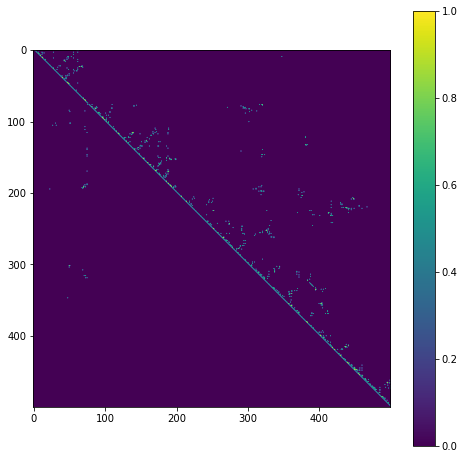

tensor([[ 77,  77,  77,  77,  77,  77,  77,  78,  78,  78,  79,  79,  79,  79],
        [ 76,  78, 319, 316, 110, 320,  82,  79, 144, 320,  80, 290, 140, 141]])

In [14]:
import torch
from torch_geometric.utils import to_dense_adj
import matplotlib.pyplot as plt

print(data.edge_index.shape)

adj_matrix = to_dense_adj(data.edge_index)
print(adj_matrix.shape)

# a = adj_matrix[0,...]
a = adj_matrix[0,:500,:500] 
fig = plt.figure(figsize=(8,8))
# plt.xticks([])
# plt.yticks([])
plt.imshow(a)
plt.colorbar()
plt.show()

data.edge_index[:,:14]

### 2. Space coordinates

Data(x=[207, 3], edge_index=[2, 526], y=1)
Graph with 207 nodes and 443 edges
<class 'numpy.ndarray'>
(207, 3)
(443, 2, 3)


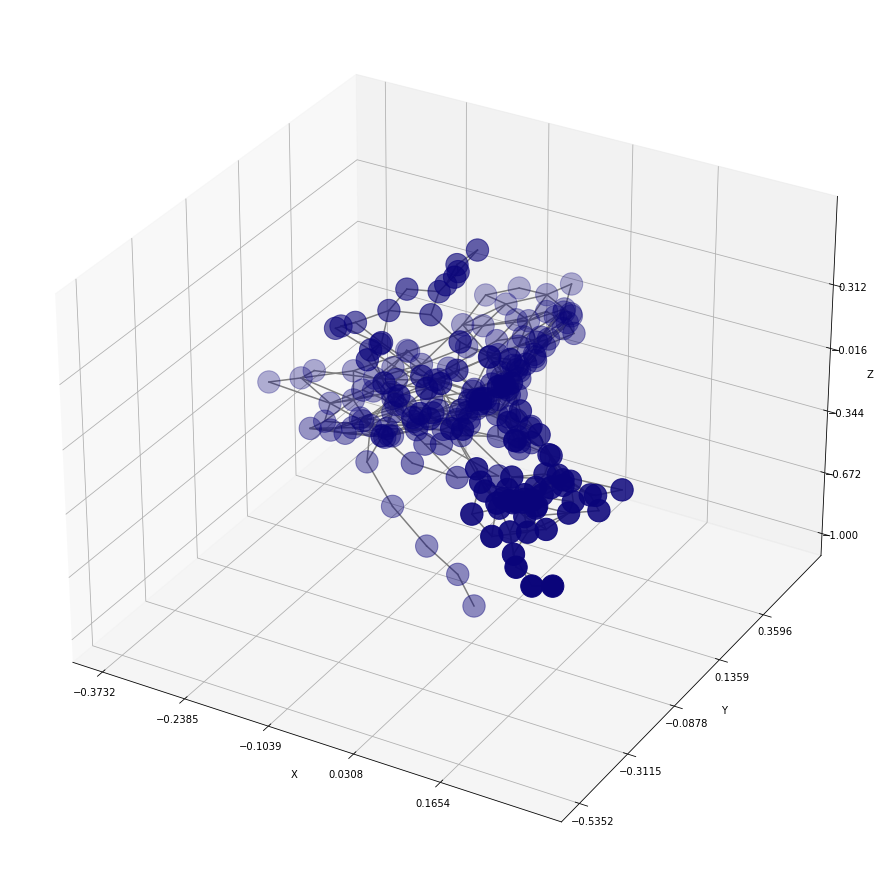

In [17]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

graph_list = []
for i, tmp_g in enumerate(val_dataset):
    node = tmp_g.x
    updated_data = Data(x=node[:,-3:], edge_index=tmp_g.edge_index, y=tmp_g.y)
    graph_list.append(updated_data)

graph_idx = 3 ############## index of graph to plot
current_graph = graph_list[graph_idx]
print(current_graph)
G = to_networkx(current_graph, to_undirected=True)
print(G)

# 3D spring layout
pos = nx.spring_layout(G, dim=3, seed=0)
print(type(pos[0]))
# print(pos)

# Extract node and edge positions from the layout
# node_xyz = np.array([pos[v] for v in sorted(G)])
node_xyz = np.array([np.multiply(pos[v], x.numpy())
                     for v, x in zip(sorted(G), current_graph.x)])
print(node_xyz.shape)
# edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])
edge_xyz = []
for i, edge_tmp in enumerate(G.edges()):
    u = edge_tmp[0]
    v = edge_tmp[1]
    a = pos[u] * current_graph.x[u,:].numpy()
    b = pos[v] * current_graph.x[v,:].numpy()
    edge_xyz.append(np.array([a, b]))
edge_xyz = np.asarray(edge_xyz)
print(edge_xyz.shape)

# Create the 3D figure
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection="3d")

# Suppress tick labels
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=500, c="#0A047A")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")

# fig.tight_layout()
ax.set_xlabel('X')
ax.set_xticks(np.arange(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0]), 
                       (np.max(node_xyz[:, 0])-np.min(node_xyz[:, 0]))/5))

ax.set_ylabel('Y')
ax.set_yticks(np.arange(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1]), 
                       (np.max(node_xyz[:, 1])-np.min(node_xyz[:, 1]))/5))

ax.set_zlabel('Z')
ax.set_zticks(np.arange(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2]), 
                       (np.max(node_xyz[:, 2])-np.min(node_xyz[:, 2]))/5))

plt.show()